In [81]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

!pip install pytorch-lightning
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp


from pprint import pprint
from torch.utils.data import DataLoader
import cv2
import numpy as np


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-nq62xz7o
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-nq62xz7o
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit c98c88d13481c956b232dec6fc13609859838d7a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [82]:
print(smp.__version__)

root2 = "/kaggle/working/"
DATA_DIR = '../input/group1/group1/'
print('data_dir saved!')

0.3.0
data_dir saved!


In [83]:
!pip install -q pytorch-lightning wandb
import wandb
wandb.login()

True

In [84]:

!ls ../input

group1	group3	group5


In [85]:
x_train_dir = os.path.join(DATA_DIR, 'train')
x_test_dir = os.path.join(DATA_DIR, 'test')
mask_dir = os.path.join(DATA_DIR,'maskdir')



train_images = list(sorted(os.listdir(x_train_dir)))
test_images = list(sorted(os.listdir(x_test_dir)))
mask_images= list(sorted(os.listdir(mask_dir)))


print('train images: ',len(train_images))
print('test images: ',len(test_images))
print('masks: ',len(mask_images))


train images:  7828
test images:  3948
masks:  7828


In [86]:
p1 = mask_images[-1]
print(p1)

011771.png


(512, 512, 3)


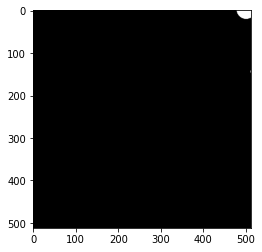

In [87]:

imgt = cv2.imread(os.path.join(mask_dir,p1))
print(np.shape(imgt))
imgt = imgt.astype(np.float32)
imgt[imgt == 2.0] = 0.0
imgt[(imgt == 1.0) | (imgt == 3.0)] = 1.0
imgt[imgt == 255.0] = 1.0
plt.imshow(imgt)
plt.show()

In [88]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project = 'G1_FPN_0.0001_GIT')

In [89]:
import os
import torch
import shutil
import numpy as np

from PIL import Image

class ZJU_Data(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory =os.path.join(self.root, "train")
        self.masks_directory = mask_dir

        self.filenames = self._read_split()  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        
        if self.mode == 'train' or self.mode == 'valid':

            filename = self.filenames[idx]
            image_path = os.path.join(self.root, 'train', filename)
            mask_path = os.path.join(self.masks_directory, filename.replace(".jpg",".png"))

            image = np.array(Image.open(image_path).convert("RGB"))

            # trimap = np.array(Image.open(mask_path))
            trimap = np.array(cv2.imread(mask_path, 0))
            mask = self._preprocess_mask(trimap)

            sample = dict(image=image, mask=mask, trimap=trimap)
            if self.transform is not None:
                sample = self.transform(**sample)

            return sample
        
        if self.mode == 'test':
           
            filename = self.filenames[idx]
            image_path = os.path.join(self.root, 'test', filename)

            image = np.array(Image.open(image_path).convert("RGB"))

            sample = dict(image=image)
            if self.transform is not None:
                sample = self.transform(**sample)

            return sample            
            

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        mask[mask == 255.0] = 1.0
        return mask

    def _read_split(self):
        if self.mode == 'train' or self.mode == 'valid':
            
            filespath = os.path.join(self.root, "train")
            filenames = [x for x in os.listdir(filespath)]
            if self.mode == "train":  # 80% for train
                filenames = [x for i, x in enumerate(filenames) if i % 5 != 0]
            elif self.mode == "valid":  # 20% for validation
                filenames = [x for i, x in enumerate(filenames) if i % 5 == 0]
            return filenames
       
        
        if self.mode == 'test':
        
            filespath = os.path.join(self.root, "test")
            filenames = [x for x in os.listdir(filespath)]
            return filenames           
     

In [90]:
class SimpleZJU_Data(ZJU_Data):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)

        # resize images
        image = np.array(Image.fromarray(sample["image"],mode = 'RGB').resize((512, 512), Image.LINEAR))
        if self.mode == 'train' or self.mode == 'valid':
            mask =  np.array(Image.fromarray(sample["mask"]).resize((512, 512), Image.NEAREST))
            trimap =np.array(Image.fromarray(sample["trimap"]).resize((512, 512), Image.NEAREST))

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        if self.mode == 'train' or self.mode == 'valid':
            sample["mask"] = np.expand_dims(mask, 0)
            sample["trimap"] = np.expand_dims(trimap, 0)

        return sample

In [91]:
train_dataset = SimpleZJU_Data(DATA_DIR, "train")
valid_dataset = SimpleZJU_Data(DATA_DIR, "valid")
test_dataset = SimpleZJU_Data(DATA_DIR, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)

Train size: 6262
Valid size: 1566
Test size: 3948


In [92]:
print(test_dataset[0])

{'image': array([[[198, 201, 203, ..., 150, 149, 145],
        [190, 192, 194, ..., 149, 151, 150],
        [179, 181, 182, ..., 147, 152, 153],
        ...,
        [202, 199, 196, ..., 142, 139, 136],
        [196, 192, 188, ..., 143, 139, 136],
        [187, 184, 180, ..., 148, 144, 140]],

       [[205, 208, 210, ..., 173, 172, 168],
        [198, 200, 202, ..., 171, 173, 172],
        [187, 189, 190, ..., 168, 173, 174],
        ...,
        [207, 204, 201, ..., 163, 160, 157],
        [203, 199, 195, ..., 164, 160, 157],
        [194, 191, 187, ..., 169, 165, 161]],

       [[211, 214, 216, ..., 223, 222, 218],
        [209, 211, 213, ..., 220, 222, 221],
        [206, 208, 209, ..., 211, 216, 217],
        ...,
        [213, 210, 207, ..., 216, 213, 210],
        [209, 205, 201, ..., 217, 213, 210],
        [202, 199, 195, ..., 222, 218, 214]]], dtype=uint8)}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys


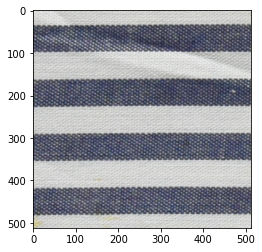

In [93]:
sample = test_dataset[3]
plt.imshow(sample['image'].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.


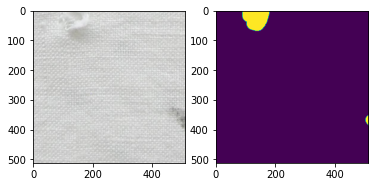

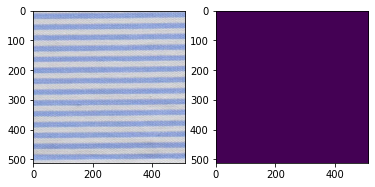

3
(1, 512, 512)
(3, 512, 512)
(512, 512)


In [94]:
sample = train_dataset[-6]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[3]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze()) # for visualization we have to remove 3rd dimension of mask
plt.show()
print(sample["mask"].ndim)
print(sample["mask"].shape)
print(sample["image"].shape)
print(sample["mask"].squeeze().shape)

In [95]:
class FabricModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        self.save_hyperparameters()

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.lvalueTrain = None
        self.lvalueValid = None
        

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)
        
        if(stage=='train'):
            self.lvalueTrain = loss
        elif(stage=='valid'):
            self.lvalueValid = loss
        self.log('train_loss', loss)
        

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        per_image_f1 = smp.metrics.f1_score(tp,fp,fn,tn,reduction = "micro-imagewise")
        dataset_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        lvalue = self.lvalueTrain if stage=='train' else self.lvalueValid
        metrics = {
#             f"{stage}_per_image_iou": per_image_iou,
#             f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_per_image_f1": per_image_f1,
            f"{stage}_dataset_f1": dataset_f1,
            f"{stage}_loss/Train": lvalue
            }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [96]:
model = FabricModel("FPN", "resnet34", in_channels=3, out_classes=1)


In [97]:
    trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
    logger = wandb_logger

)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader
)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

In [98]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: NEAREST is deprecated and will be re

[{'train_loss': 0.19537600874900818,
  'valid_dataset_f1': 0.8083793520927429,
  'valid_loss/Train': 0.23723214864730835,
  'valid_per_image_f1': 0.9315392374992371}]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  import sys


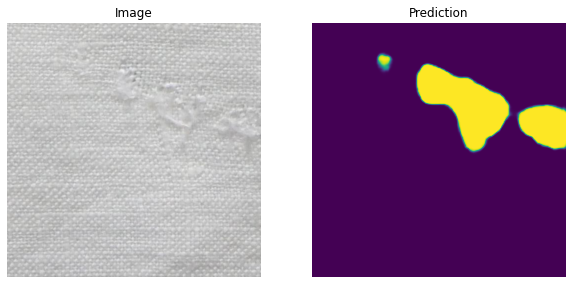

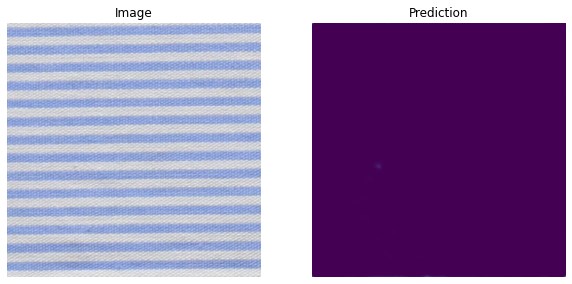

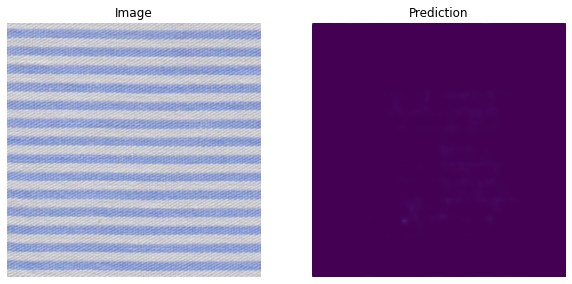

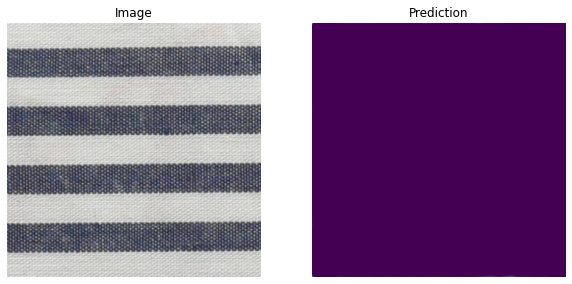

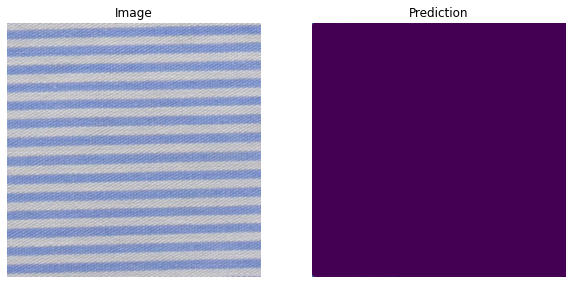

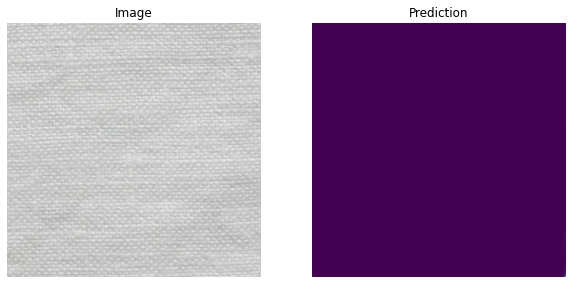

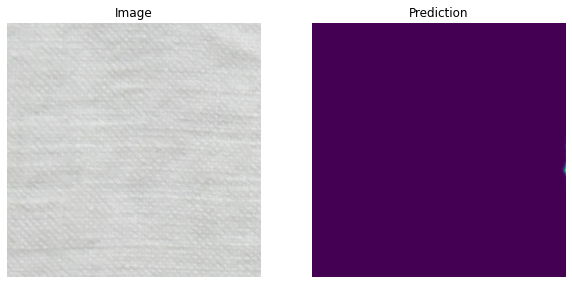

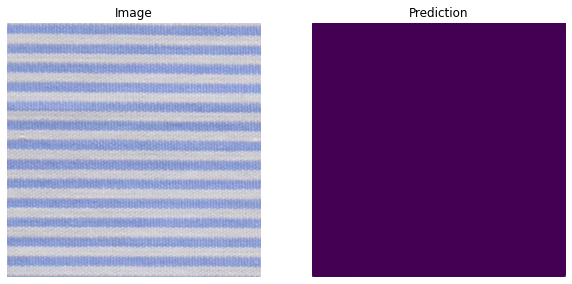

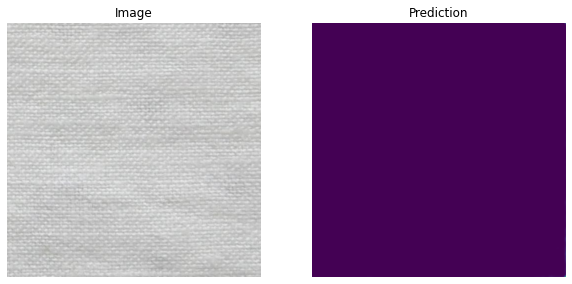

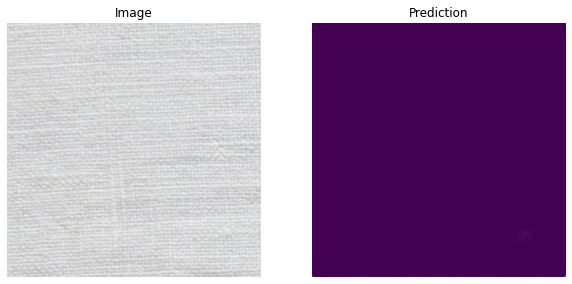

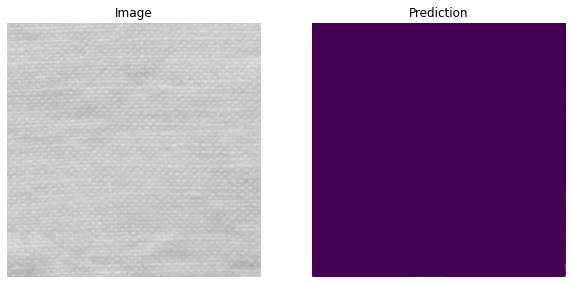

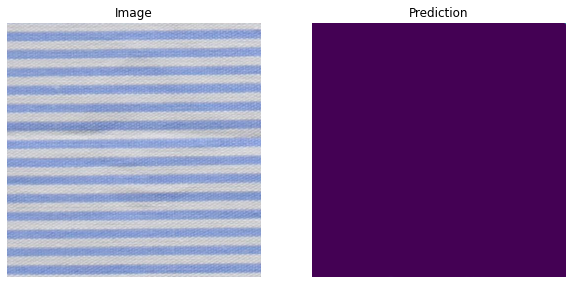

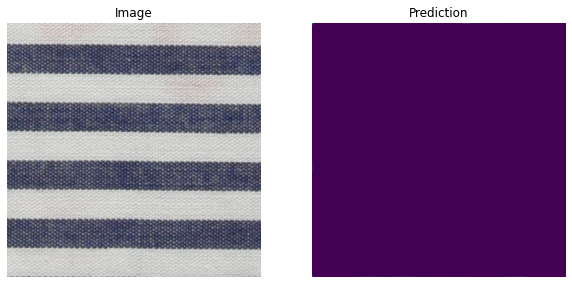

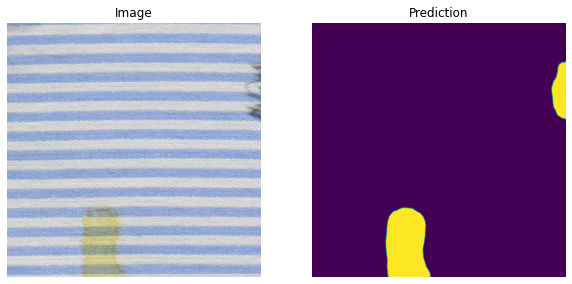

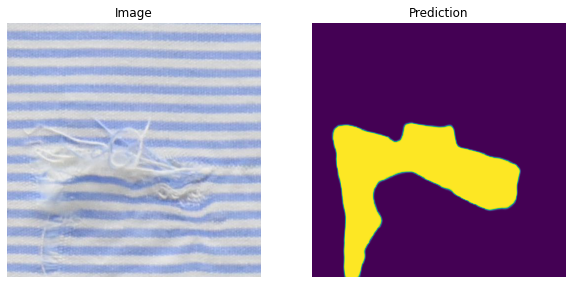

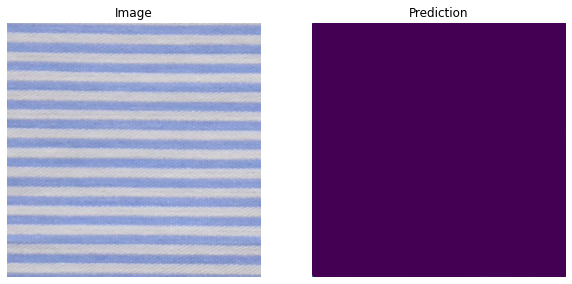

In [99]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, pr_mask in zip(batch["image"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
    

In [100]:
wandb.finish()

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/wandb/apis/normalize.py", line 22, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/internal_api.py", line 1429, in upload_urls
    run = query_result["model"]["bucket"]
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/wandb/filesync/upload_job.py", line 56, in run
    success = self.push()
  File "/opt/conda/lib/python3.7/site-packages/wandb/filesync/upload_job.py", line 107, in push
    _, upload_headers, result = self._api.upload_urls(project, [self.save_name])
  File "/opt/conda/lib/python3.7/site-packages/wandb/apis/normalize.py", line 58, in wrapper
    raise CommErro

epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█
train_dataset_f1,▁▇▇██
train_loss,▆▆█▅▄▅▇▄▅▄▃▆▄▄▄▄▄▃▄▃▅▅▄▄▃▄▄▃▄▅▄▄▅▄▄▄▃▅▁▄
train_loss/Train,▁█▄▇▇
train_per_image_f1,▁▅▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
valid_dataset_f1,▁▅▇▇██
valid_loss/Train,▆▅▄▁█▇
valid_per_image_f1,▁▇▇▇██
epoch,5
train_dataset_f1,0.82843
